# Import Libraries

In [19]:
import numpy as np 
import pandas as pd

from PIL import ImageFile
from tqdm import tqdm
import h5py
import cv2

import matplotlib.pylab as plt
from matplotlib import cm
%matplotlib inline

from sklearn.model_selection import train_test_split

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image as keras_image

from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, GlobalAveragePooling1D, GlobalAveragePooling2D
from tensorflow.keras.layers import Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.layers import PReLU, LeakyReLU
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
import seaborn as sns

   # Data Preprocessing

In [20]:
#Load Image and convert into Array
def image_to_tensor(img_path):
    img = keras_image.load_img('C://Users//vikas//flower_dataset//archive//flower_images//flower_images//' + img_path, target_size=(128, 128))
    x = keras_image.img_to_array(img)
    return np.expand_dims(x, axis=0)

In [21]:
#convert Image into Tensors
def data_to_tensor(img_paths):
    list_of_tensors = [image_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

In [22]:
##Load the Data
ImageFile.LOAD_TRUNCATED_IMAGES = True 
# Load the data
data = pd.read_csv('C://Users//vikas//flower_dataset//archive//flower_images//flower_images//flower_labels.csv')
files = data['file']
targets = data['label'].values
tensors = data_to_tensor(files);

100%|██████████████████████████████████████████████████████████████████████████████| 210/210 [00:00<00:00, 1077.55it/s]


In [23]:
data.head()

,file,label
0,0001.png,0
1,0002.png,0
2,0003.png,2
3,0004.png,0
4,0005.png,0


In [24]:
tensors.shape

(210, 128, 128, 3)

In [25]:
targets.shape

(210,)

In [26]:
# Name list
names = ['phlox', 'rose', 'calendula', 'iris', 'max chrysanthemum', 
         'bellflower', 'viola', 'rudbeckia laciniata', 'peony', 'aquilegia']

In [37]:
##Display sample images
def display_images(img_path, ax):
    img = cv2.imread('C://Users//vikas//flower_dataset//archive//flower_images//flower_images//' + img_path)
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

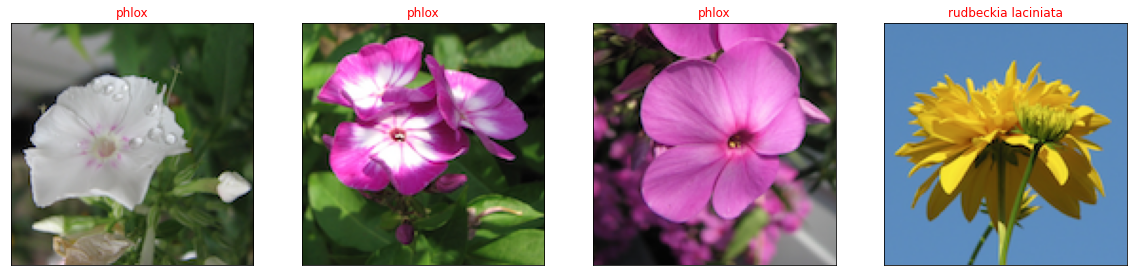

In [38]:
fig = plt.figure(figsize=(20, 10))
for i in range(4):
    ax = fig.add_subplot(2, 4, i + 1, xticks=[], yticks=[])
    ax.set_title(names[targets[i+10]], color='Red')
    display_images(files[i+10], ax)

In [ ]:
##Save data in H5 file for future use

In [39]:
# Create h5 file and save data
with h5py.File('FlowerColorImages.h5', 'w') as f:
    f.create_dataset('images', data = tensors)
    f.create_dataset('labels', data = targets)
    f.close()

In [40]:
# Read the h5 file
f = h5py.File('FlowerColorImages.h5', 'r')

# List all groups
keys = list(f.keys())
keys

['images', 'labels']

In [41]:
tensors = np.array(f[keys[0]])
targets = np.array(f[keys[1]])
print ('Tensor shape:', tensors.shape)
print ('Target shape', targets.shape)

Tensor shape: (210, 128, 128, 3)
Target shape (210,)


In [42]:
# Create a csv file and save data
images_csv = tensors.reshape(210,128*128*3)
np.savetxt("flower_images.csv", images_csv, fmt='%i', delimiter=",")

In [43]:
# Read the pandas dataframe from csv
data_images = pd.read_csv("flower_images.csv", header=None)
data_images.head()

,0,1,2,3,4,5,6,7,8,9,...,49142,49143,49144,49145,49146,49147,49148,49149,49150,49151
0,13,22,10,14,23,9,16,24,10,16,...,44,59,38,38,26,25,16,117,74,78
1,38,49,30,37,50,30,38,52,30,40,...,9,9,10,8,7,7,7,5,5,5
2,65,83,48,72,87,58,74,90,62,81,...,35,52,70,38,56,74,41,58,76,42
3,162,53,102,147,66,91,156,80,97,169,...,69,105,44,67,103,43,68,103,43,68
4,193,52,78,194,51,76,195,58,85,197,...,199,253,179,200,248,163,189,229,120,154


In [44]:
data_images.iloc[:10,:10]

,0,1,2,3,4,5,6,7,8,9
0,13,22,10,14,23,9,16,24,10,16
1,38,49,30,37,50,30,38,52,30,40
2,65,83,48,72,87,58,74,90,62,81
3,162,53,102,147,66,91,156,80,97,169
4,193,52,78,194,51,76,195,58,85,197
5,53,76,55,53,76,55,53,77,56,53
6,8,9,8,8,9,9,9,9,9,8
7,9,9,8,9,9,9,8,8,8,8
8,195,127,169,188,118,160,135,76,101,55
9,7,7,7,8,7,7,8,9,8,9


In [45]:
data_images.shape

(210, 49152)

In [46]:
# Read image tensors from the dataframe
tensors = data_images.values
tensors.shape

(210, 49152)

In [47]:
tensors = tensors.reshape(-1,128,128,3)
tensors.shape

(210, 128, 128, 3)

In [48]:
tensors = tensors.astype('float32')/255

In [49]:
targets = to_categorical(targets, 10)

In [50]:
x_train, x_test, y_train, y_test = train_test_split(tensors, targets, 
                                                    test_size = 0.2, 
                                                    random_state = 1)
n = int(len(x_test)/2)
x_valid, y_valid = x_test[:n], y_test[:n]
x_test, y_test = x_test[n:], y_test[n:]

In [51]:
x_train.shape, y_train.shape

((168, 128, 128, 3), (168, 10))

In [52]:
x_test.shape, y_test.shape

((21, 128, 128, 3), (21, 10))

In [53]:
x_valid.shape, y_valid.shape

((21, 128, 128, 3), (21, 10))

Label:  max chrysanthemum


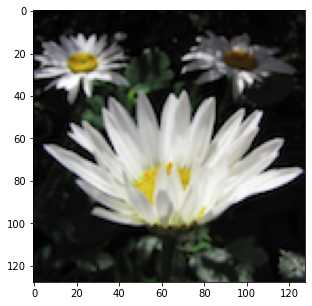

In [56]:
# Read and display a tensor
print('Label: ', names[np.argmax(y_train[1])])
plt.figure(figsize=(10,5))
plt.imshow((x_train[1]));

In [57]:
def model():
    model = Sequential()

    model.add(Conv2D(128, (3, 3), input_shape=x_train.shape[1:]))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(128, (3, 3)))
    model.add(LeakyReLU(alpha=0.02))
    
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(GlobalMaxPooling2D())
    
    model.add(Dense(512))
    model.add(LeakyReLU(alpha=0.02))
    model.add(Dropout(0.5)) 

    model.add(Dense(10))
    model.add(Activation('softmax'))
    
    # TODO: Compile the model
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    return model

model = model()

In [58]:
# To save the best model
checkpointer = ModelCheckpoint(filepath='weights.best.model.hdf5', 
                               verbose=2, save_best_only=True)

# To reduce learning rate dynamically
lr_reduction = ReduceLROnPlateau(monitor='val_loss', 
                                 patience=5, verbose=2, factor=0.2)

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 128)     3584      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 126, 126, 128)     0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 128)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 63, 128)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 128)       147584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 61, 61, 128)       0         
                                                        

In [60]:
history = model.fit(x_train, y_train, 
                    epochs=75, batch_size=32, verbose=2,
                    validation_data=(x_valid, y_valid),
                    callbacks=[checkpointer,lr_reduction])

Epoch 1/75

Epoch 1: val_loss improved from inf to 2.28863, saving model to weights.best.model.hdf5
6/6 - 5s - loss: 2.3391 - accuracy: 0.1071 - val_loss: 2.2886 - val_accuracy: 0.1429 - lr: 0.0010 - 5s/epoch - 779ms/step
Epoch 2/75

Epoch 2: val_loss improved from 2.28863 to 2.28392, saving model to weights.best.model.hdf5
6/6 - 4s - loss: 2.2894 - accuracy: 0.1429 - val_loss: 2.2839 - val_accuracy: 0.1429 - lr: 0.0010 - 4s/epoch - 635ms/step
Epoch 3/75

Epoch 3: val_loss improved from 2.28392 to 2.24754, saving model to weights.best.model.hdf5
6/6 - 4s - loss: 2.1826 - accuracy: 0.2024 - val_loss: 2.2475 - val_accuracy: 0.2381 - lr: 0.0010 - 4s/epoch - 695ms/step
Epoch 4/75

Epoch 4: val_loss improved from 2.24754 to 2.15620, saving model to weights.best.model.hdf5
6/6 - 4s - loss: 2.1134 - accuracy: 0.3095 - val_loss: 2.1562 - val_accuracy: 0.2381 - lr: 0.0010 - 4s/epoch - 683ms/step
Epoch 5/75

Epoch 5: val_loss improved from 2.15620 to 2.06254, saving model to weights.best.model.h

Epoch 40/75

Epoch 40: val_loss did not improve from 0.62006
6/6 - 4s - loss: 0.4779 - accuracy: 0.8214 - val_loss: 0.6815 - val_accuracy: 0.7619 - lr: 0.0010 - 4s/epoch - 642ms/step
Epoch 41/75

Epoch 41: val_loss did not improve from 0.62006
6/6 - 4s - loss: 0.4566 - accuracy: 0.8393 - val_loss: 0.6766 - val_accuracy: 0.7619 - lr: 0.0010 - 4s/epoch - 671ms/step
Epoch 42/75

Epoch 42: val_loss improved from 0.62006 to 0.56424, saving model to weights.best.model.hdf5
6/6 - 4s - loss: 0.4030 - accuracy: 0.8512 - val_loss: 0.5642 - val_accuracy: 0.8095 - lr: 0.0010 - 4s/epoch - 654ms/step
Epoch 43/75

Epoch 43: val_loss did not improve from 0.56424
6/6 - 4s - loss: 0.4277 - accuracy: 0.8274 - val_loss: 0.6785 - val_accuracy: 0.7619 - lr: 0.0010 - 4s/epoch - 637ms/step
Epoch 44/75

Epoch 44: val_loss did not improve from 0.56424
6/6 - 4s - loss: 0.4024 - accuracy: 0.8571 - val_loss: 0.5695 - val_accuracy: 0.8095 - lr: 0.0010 - 4s/epoch - 650ms/step
Epoch 45/75

Epoch 45: val_loss did not 

In [61]:
data_generator = keras_image.ImageDataGenerator(shear_range=0.3, 
                                                zoom_range=0.3,
                                                rotation_range=30,
                                                horizontal_flip=True)

dg_history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),
                                 steps_per_epoch = len(x_train)//64, epochs=7, verbose=2, 
                                 validation_data=(x_valid, y_valid),
                                 callbacks=[checkpointer,lr_reduction])

Epoch 1/7


C:\Users\vikas\AppData\Local\Temp\ipykernel_33220\2513234589.py:6: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  dg_history = model.fit_generator(data_generator.flow(x_train, y_train, batch_size=64),



Epoch 1: val_loss did not improve from 0.48569
2/2 - 3s - loss: 0.3667 - accuracy: 0.8846 - val_loss: 0.4970 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 3s/epoch - 2s/step
Epoch 2/7

Epoch 2: val_loss did not improve from 0.48569
2/2 - 3s - loss: 0.3565 - accuracy: 0.8654 - val_loss: 0.4970 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 3s/epoch - 1s/step
Epoch 3/7

Epoch 3: val_loss did not improve from 0.48569
2/2 - 3s - loss: 0.3411 - accuracy: 0.8828 - val_loss: 0.4971 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 3s/epoch - 2s/step
Epoch 4/7

Epoch 4: val_loss did not improve from 0.48569
2/2 - 3s - loss: 0.3749 - accuracy: 0.8654 - val_loss: 0.4972 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 3s/epoch - 1s/step
Epoch 5/7

Epoch 5: val_loss did not improve from 0.48569
2/2 - 2s - loss: 0.2929 - accuracy: 0.8846 - val_loss: 0.4972 - val_accuracy: 0.8571 - lr: 1.6000e-06 - 2s/epoch - 1s/step
Epoch 6/7

Epoch 6: val_loss did not improve from 0.48569

Epoch 6: ReduceLROnPlateau reducing learning r

In [62]:
# Load the model with the best validation accuracy
model.load_weights('weights.best.model.hdf5')

In [63]:
##Model Evaluation
    

In [64]:
# Calculate classification accuracy on the testing set
score = model.evaluate(x_test, y_test)
score

1/1 [==============================] - 0s 107ms/step - loss: 0.7657 - accuracy: 0.7619


[0.7656572461128235, 0.761904776096344]

In [65]:
# Calculate classification accuracy on the training set
score = model.evaluate(x_train, y_train)
score

6/6 [==============================] - 1s 121ms/step - loss: 0.2732 - accuracy: 0.9643


[0.27315422892570496, 0.9642857313156128]

In [66]:
# Calculate classification accuracy on the validation set
score = model.evaluate(x_valid, y_valid)
score

1/1 [==============================] - 0s 109ms/step - loss: 0.4857 - accuracy: 0.8571


[0.485685795545578, 0.8571428656578064]

# Accuracy Plot

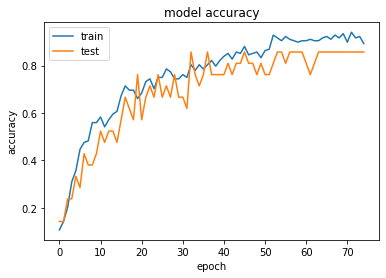

In [67]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Loss Plot

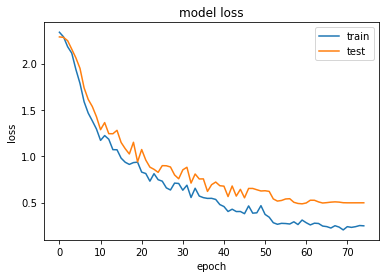

In [68]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()

In [69]:
model.save('model.h5')

In [70]:
model1 = load_model('model.h5')

# Predictions

In [71]:
# Model predictions for the testing dataset
y_test_predict = model1.predict(x_test)

In [72]:
y_test_predict = np.argmax(y_test_predict,axis=1)

# Display Predictions

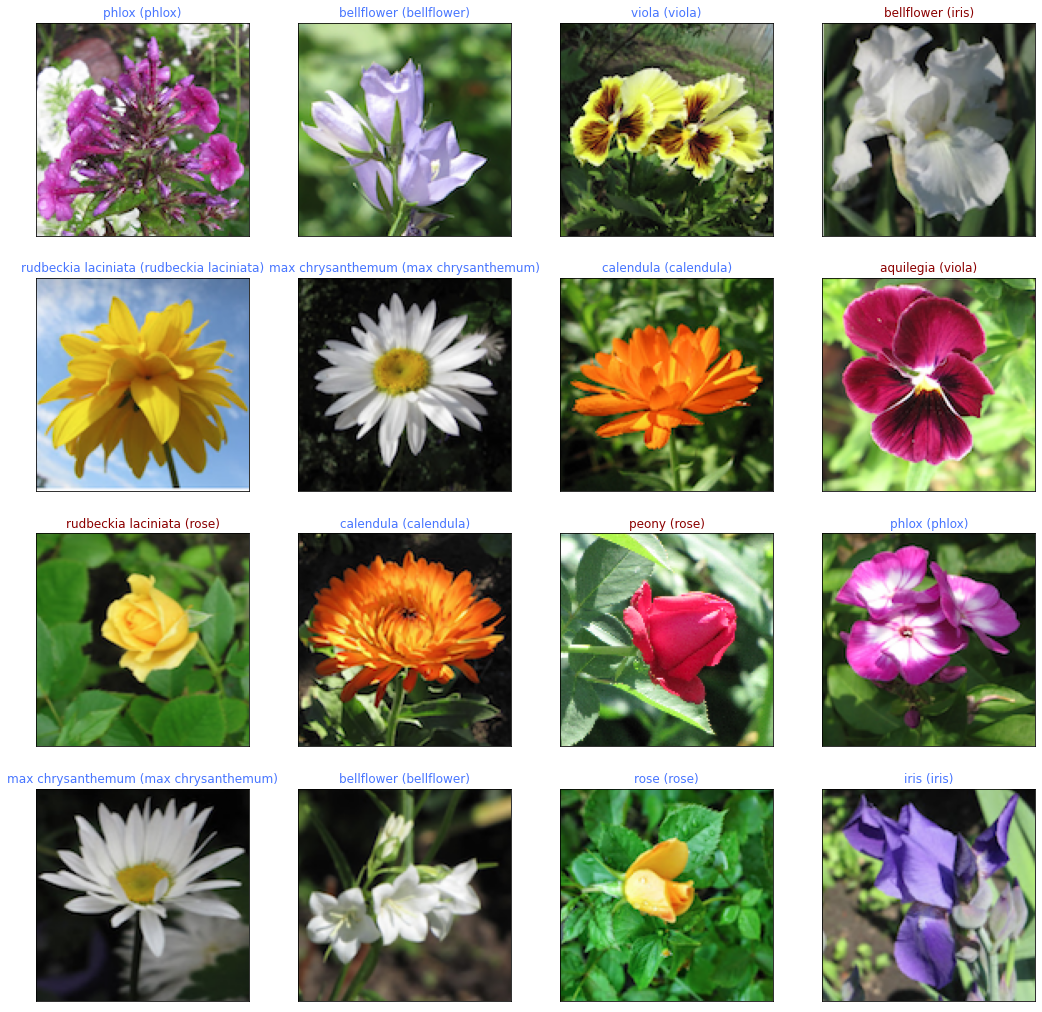

In [73]:
# Display true labels and predictions
fig = plt.figure(figsize=(18, 18))
for i, idx in enumerate(np.random.choice(x_test.shape[0], size=16, replace=False)):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    ax.imshow(np.squeeze(x_test[idx]))
    pred_idx = y_test_predict[idx]
    true_idx = np.argmax(y_test[idx])
    ax.set_title("{} ({})".format(names[pred_idx], names[true_idx]),
                 color=("#4876ff" if pred_idx == true_idx else "darkred"))

# Plot Confusion Matrix

In [74]:
y_test_orig = []

In [75]:
for i in y_test:
  y_test_orig.append(np.argmax(i))

In [76]:
y_test_orig = np.array(y_test_orig)

In [77]:
y_test_orig

array([6, 3, 4, 9, 2, 0, 7, 6, 1, 2, 4, 0, 6, 0, 3, 1, 6, 5, 5, 7, 1],
      dtype=int64)

In [78]:
y_test_predict

array([6, 5, 4, 9, 2, 0, 7, 9, 8, 2, 4, 8, 6, 0, 3, 7, 6, 5, 5, 7, 1],
      dtype=int64)

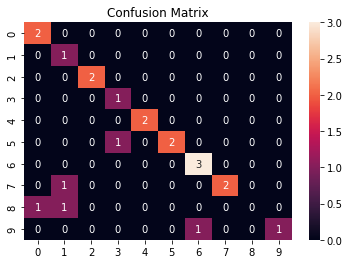

In [79]:
#Plotting a confusion matrix
cnf = confusion_matrix(y_test_predict,y_test_orig)


df_cnf = pd.DataFrame(cnf, range(10), range(10))
sns.heatmap(df_cnf, annot = True)
plt.title("Confusion Matrix")
plt.show()

# DeepCC